#### DICOM imgages
(C) MK & ASL & AL

Created: 2019.11.11

Modified: 2019.11.22

In [1]:
import os
import numpy as np
import pydicom as dicom
import matplotlib.pyplot as plt

# our imports
import mkViewer2A as mkv
import functions1 as f1
import functions2 as f2

#import imp
#imp.reload(f2)

#### Main script 

In [2]:
# setting main paths
adniPth = os.path.join('/','media','mk','p1ext4','no19','adni')
adniMainPth = os.path.join(adniPth, 'ADNI_from_Alexander', 'DownloadedNIfTI')
folder = os.path.join(adniMainPth, 'ADNI')


# There are 4 statistiscs: min, max, mean, std for each 2D slice or the whole 3D array

# Paths to output folders
# There are images inside ; ~170 x 2D DICOM slices are assembled to one 3D NPY array (for each acquisition)
dcm2npyPth = os.path.join(adniMainPth, 'DCM2NPY')  
# There are arrays inside (one for an acquisition); stat. params for each 2D DICOM image (~170 rows x 4 columns)
statslPth = os.path.join(adniMainPth, 'STATSL') 
# There are arrays inside (one for each acquisition); stats for one 3D image (4,)
statim3dPth = os.path.join(adniMainPth, 'STATIM3D') 

# A global variable
PRINT = False

os.chdir(folder)
f1.pthInfo()

Current folder is:
	/media/mk/p1ext4/no19/adni/ADNI_from_Alexander/DownloadedNIfTI/ADNI


##### Number of all subject folders in my database (ADNI) - 1488 objects

In [3]:
! ls | wc -l

1488


##### Number of all *.dcm images in subfolders

In [4]:
!find . -type f -iname "*.dcm" | wc -l

305613


##### A tree structure in ADNI folders

    ---> ADNI
        ---> SUBJECT          (e.g. 002_S_0295)  
            ---> MT1__N3m     (acquisitions)
            ---> MP-RAGE
            ---> MPRAGE                
                    ---> 2009-04-30_10_58_19.0         (acquistion date)
                                ---> S666999           (nobody knows...;P )
                                        ---> DCM files (x 170, DICOM 2D images)

##### Convertion from 2D DICOMs to one 3D NPY array

In [5]:
# Walk through a folder tree in ADNI main directory,
# convert 2D DICOM slices in into one 3D NPY array in each subfolder

os.chdir(folder)
f1.pthInfo()

# find all subjects
subDirs = os.listdir('.')
subDirs = [d for d in subDirs if os.path.isdir(d)]
subDirs.sort()
subCnt = 0

# Look for "MPRAGE", "MP-RAGE"
nameToFind = 'rage'

# an limitation of processed folders
dirsToProcess = 5

# go into subject dir 
for sub in subDirs[:dirsToProcess]: 
    subCnt += 1
    # print convertion progress
    f1.progress(subCnt, dirsToProcess)
    
    os.chdir(sub)
    examsDir = os.listdir('.')
    examsDir = [d for d in examsDir if os.path.isdir(d)]
    examsDir = [d for d in examsDir if nameToFind in d.lower()]
    
    for exam in examsDir:
        os.chdir(exam)
        dateDirs = os.listdir('.')
        for date in dateDirs:
            os.chdir(date)
            sDirs = os.listdir('.')
            for s in sDirs:
                os.chdir(s)
                dcmFiles = os.listdir('.')
                dcmFiles = [f for f in dcmFiles if f.lower().endswith('.dcm')]
                
                ##############################################################
                # here should be a main part of the convertion

                # convertion from DICOM to Nifti
                saveName = "{}-{}.npy".format(sub, s)
                if PRINT:
                    text_wrap(saveName)
                savePth = os.path.join(dcm2npyPth, saveName) # DCM2NPY folder
                im3dx = f2.convertDICOM2NPY(savePth)  
                
                ##############################################################             
                
                # go up from s
                os.chdir('../')
            # go up from date
            os.chdir('../')    
        # go up form exam
        os.chdir('../')    
    # go up from sub
    os.chdir('../')

Current folder is:
	/media/mk/p1ext4/no19/adni/ADNI_from_Alexander/DownloadedNIfTI/ADNI


---

#### Image statisitcs based on 3D NPY arrays

In [6]:
# This part bases on already CREATED 3D NPY arrays from set of 2D DICOM images (in folder: DCM2NPY)

# loads 3D NPY arrays with image pixel values,
# counts and save their statistics to dedicated folders:
#          STATIM3D - for whole 3D array,
#          STATSL - for each 2D slice separately.)

os.chdir(dcm2npyPth)
f1.pthInfo()

npy_files = os.listdir('.')
npy_files.sort()

cnt = 0 # counter
for f in npy_files:   
    cnt += 1
    cnt_full = len(npy_files)
    f1.progress(cnt, cnt_full)
    
    name, ext = os.path.splitext(f)
    # create a file name with two parts: subject and this "Sxxxx" (?)
    sub, s = name.split('-')

    im3dd = np.load(f)
    # each name receives an prefix
    saveNameSL = "{}-{}-{}.npy".format(sub, s, 'statSL') # for 2D slices separately
    savePthSL = os.path.join(statslPth, saveNameSL)                
    saveNameIm3d = "{}-{}-{}.npy".format(sub, s, 'statIm3d') # for the whole 3D array
    savePthIm3d = os.path.join(statim3dPth, saveNameIm3d)
    # pass loaded 3D data to get/count parameters and save them to apropriate folders: STATSL and STATIM3D
    f2.getStatistics(im3dd, savePthSL, savePthIm3d)    

Current folder is:
	/media/mk/p1ext4/no19/adni/ADNI_from_Alexander/DownloadedNIfTI/DCM2NPY


#### Plot raw statistic parameter values for 2D slices - without normalization

Current folder is:
	/media/mk/p1ext4/no19/adni/ADNI_from_Alexander/DownloadedNIfTI/STATSL


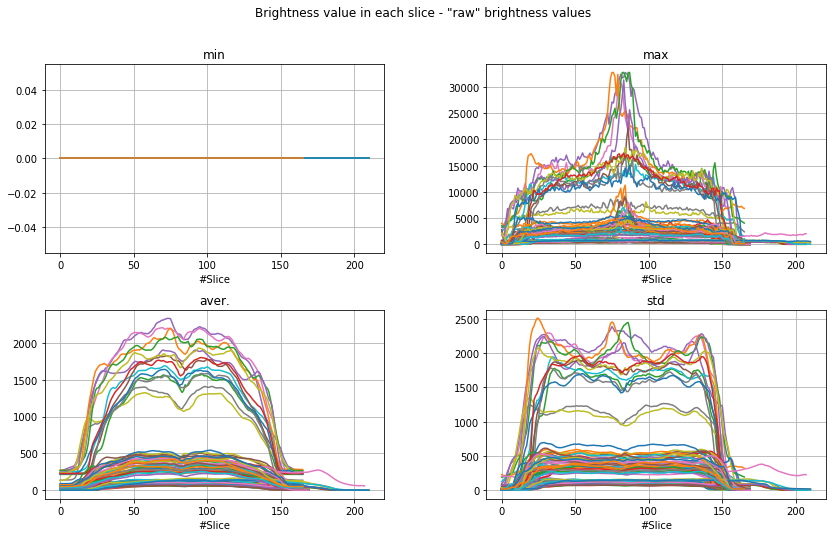

In [16]:
# plot of all slice statistisc from a STATSL folder

if 0: 
    %matplotlib qt5    
else:
    %matplotlib inline

# go in a folder
os.chdir(statslPth)
f1.pthInfo()

sl_files = os.listdir('.')
sl_files.sort()

fig, ax = plt.subplots(2,2, figsize=(14,8))
mainTitle = 'Brightness value in each slice - "raw" brightness values'
xLabel = '#Slice'

for k, f in enumerate(sl_files):
    statSL = np.load(f)    
    f2.plot4stats(statSL, mainTitle, xLabel, fig, ax, line='-')

#### Plot statistic parameter values for 2D slices - with normalization

Current folder is:
	/media/mk/p1ext4/no19/adni/ADNI_from_Alexander/DownloadedNIfTI/STATSL


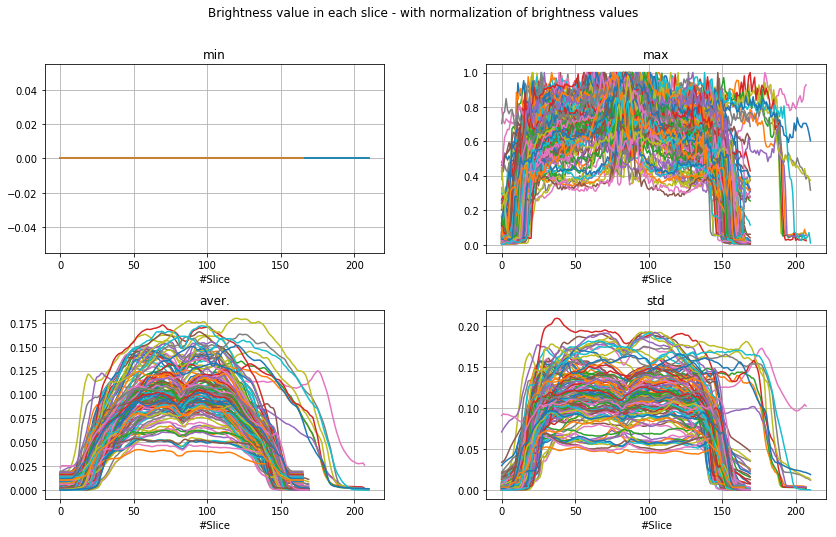

In [21]:
# plot of all slice statistisc from a STATSL folder

if 0: 
    %matplotlib qt5    
else:
    %matplotlib inline

# go in a folder
os.chdir(statslPth)
f1.pthInfo()

sl_files = os.listdir('.')
sl_files.sort()

fig, ax = plt.subplots(2,2, figsize=(14,8))
mainTitle = 'Brightness value in each slice - with normalization of brightness values'
xLabel = '#Slice'

for k, f in enumerate(sl_files):
    im = np.load(f) 
    
    # image values normalization to <0,1>
    imN = im/im.max()
    
    f2.plot4stats(imN, mainTitle, xLabel, fig, ax, line='-')

#### Plot statistic parameter values for 2D slices - with standarization

Current folder is:
	/media/mk/p1ext4/no19/adni/ADNI_from_Alexander/DownloadedNIfTI/STATSL


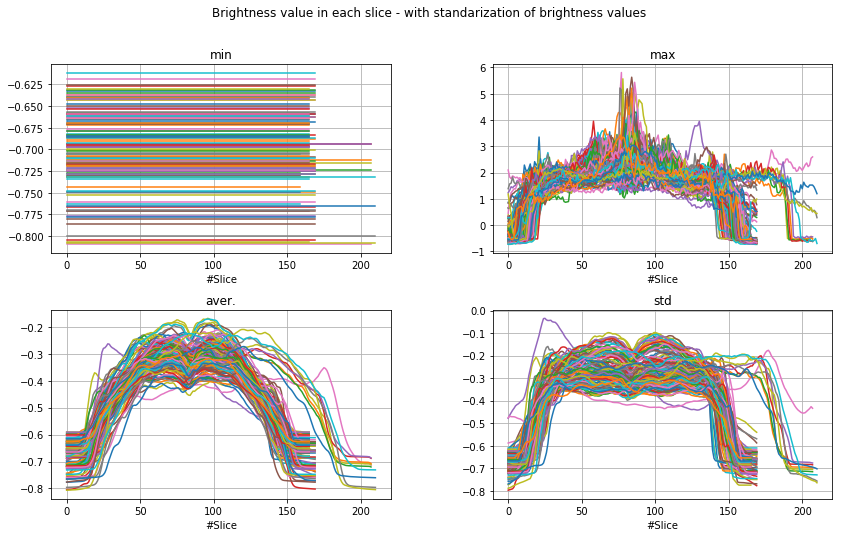

In [20]:
# plot of all slice statistisc from a STATSL folder

if 0: 
    %matplotlib qt5    
else:
    %matplotlib inline

# go in a folder
os.chdir(statslPth)
f1.pthInfo()

sl_files = os.listdir('.')
sl_files.sort()

fig, ax = plt.subplots(2,2, figsize=(14,8))
mainTitle = 'Brightness value in each slice - with standarization of brightness values'
xLabel = '#Slice'

for k, f in enumerate(sl_files):
    im = np.load(f) 
    
    # image values standarization z = (x-mi)/std
    imS = (im - im.mean()) / im.std()
    
    f2.plot4stats(imS, mainTitle, xLabel, fig, ax, line='-')

#### Scatter plots for 3D image statisitcs

Current folder is:
	/media/mk/p1ext4/no19/adni/ADNI_from_Alexander/DownloadedNIfTI/STATIM3D


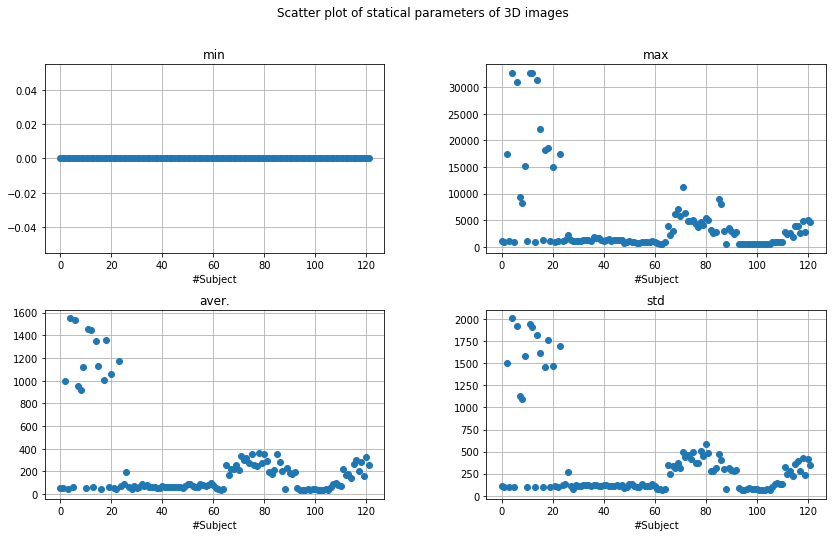

In [8]:
# plot of all slice statistisc from a STATIM3D folder
if 0: 
    %matplotlib qt5    
else:
    %matplotlib inline

# go in a folder
os.chdir(statim3dPth)
f1.pthInfo()

d3_files = os.listdir('.')
d3_files.sort()

# put all into one matrix
stat_all = np.zeros((len(d3_files),4), dtype=np.float32)

for k,f in enumerate(d3_files):
    stat = np.load(f)
    stat_all[k]= stat       
    
fig, ax = plt.subplots(2,2, figsize=(14,8))
mainTitle = 'Scatter plot of statical parameters of 3D images'
xLabel = '#Subject'   

f2.plot4stats(stat_all, mainTitle, xLabel, fig, ax, line='o')

#### 3D scatter plot 

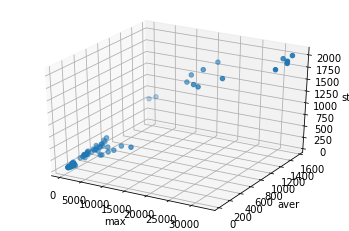

In [13]:
if 0: 
    %matplotlib qt5
else:
    %matplotlib inline
    
f2.statParamsScatter(stat_all)

---

#### Visualization

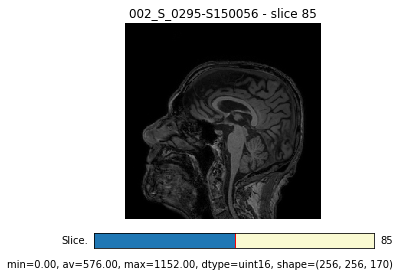

In [15]:
# display numpy image
if 0: 
    %matplotlib qt5
else:
    %matplotlib inline
import mkViewer2A as mkv

fileName = '002_S_0295-S150056.npy'
im3d = np.load(os.path.join(dcm2npyPth, fileName))
name, ext = os.path.splitext(fileName) 

tracker = mkv.IndexTracker(im3d, 'gray', title=name, rot=False)